# T011 ·查询在线 API Web 服务

**注意：** 此讲座是 TeachOpenCADD 的一部分，该平台旨在教授特定领域的技能并提供管道模板作为研究项目的起点。

作者:

- Jaime Rodríguez-Guerra, 2020-2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- David Schaller, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## 本次演讲的目的

在本笔记本中，您将学习如何在药物设计的上下文中以编程方式使用 Python 中的在线 Web 服务。在本次演讲结束时，您将熟悉 REST 服务和 Web Scraping。

### 理论内容

* 从服务器端角度访问数据

### 实用内容

* 下载静态文件
* 访问动态生成的内容
* 编程接口
* 文档解析
* 浏览器远程控制

### 参考资料

本指南非常实用，为了清晰起见，省略了一些技术定义。但是，您还应该处理一些基本术语，以充分了解幕后发生的事情。

* [客户端-服务器模式]（https://en.wikipedia.org/wiki/Client%E2%80%93server_model）
* [Web API]（https://en.wikipedia.org/wiki/Web_API）
* [查询字符串]（https://en.wikipedia.org/wiki/Query_string）
* [REST]（https://en.wikipedia.org/wiki/Representational_state_transfer）
* [JSON]（https://en.wikipedia.org/wiki/JSON）
* [Swagger / OpenAPI]（https://en.wikipedia.org/wiki/Swagger_（软件））
* [HTTP 概述]（https://developer.mozilla.org/en-US/docs/Web/HTTP/Overview）

## 理论

Internet 是交换数据的已连接计算机的集合。在某种程度上，您基本上是使用某些参数查询计算机（服务器）以检索特定数据。该数据将是：

-**A**。立即提供，因为服务器只是一个文件存储库。例如，您可以从他们的服务器 [下载 ChEMBL 数据库转储]（ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/）。
- **B**。从数据库中检索并以特定方式格式化。您在浏览器上看到的结果是：
    - **B1**。在服务器上进行预处理，例如，当您访问任何 [维基百科中的文章]（https://en.wikipedia.org/wiki/Drug_design） 时看到的 HTML 页面。
    - **B2**。当您使用网站时在客户端（您的浏览器）上动态生成，例如 Twitter、Facebook 或任何现代_web app_。
- **C**.通过在服务器端执行一个或多个程序来计算，例如使用 [Protoss]（https://proteins.plus/help/tutorial） 估计蛋白质-配体复合物的质子化状态。

> 在某种程度上，配置 **C** 是 **B1** 的一种特殊类型。您只是替换了在服务器上运行的任务类型：数据库查询和 HTML 呈现 _vs._ 计算，用于处理查询并返回以特定于域的方式格式化的数据。
对在线服务进行分类的另一种方法是按返回数据的 _format_ 进行分类。您在浏览器上看到的大多数页面都使用 HTML，通常侧重于以人类可读的方式呈现数据。但是，某些服务器可能会以 _machine_ 可读的方式构建该数据。这些数据可以以可靠的方式处理，因为它使用一组一致的规则进行格式化，这些规则可以很容易地在程序中编码。此类程序通常称为 _parsers_。HTML 可以以这样一种方式进行标记，以便可靠地获取数据，但它的设计并未考虑该目的。因此，我们通常更喜欢使用提供机器可读格式的服务，例如 JSON、CSV 或 XML。
在实践中，两种数据表示方式（应该）和谐共存。现代 Web 架构努力将数据检索任务与最终用户演示分开。一种流行的实现方式包括使用编程终端节点，该终端节点返回机器可读的 JSON 数据，然后由面向用户的 Web 应用程序使用。后者在服务器 -option B1**-或用户的浏览器 -option B2** 上呈现 HTML。遗憾的是，与面向用户的应用程序不同，编程端点 （API） 不能保证公开可用，有时仅限于服务器端的内部使用。

在以下部分中，我们将讨论如何使用 Python 和一些库充分利用每种类型的在线服务！

## 实用

In [1]:
from pathlib import Path

HERE = Path(_dh[-1])
DATA = HERE / "data"
TMPDATA = DATA / "_tmp"  # this dir is gitignored
TMPDATA.mkdir(parents=True, exist_ok=True)

### 下载静态文件

在这种情况下，Web 服务器托管您将立即下载和使用的文件。您需要做的就是 _query_ 服务器以获取正确的地址或 _URL_（通用资源位置）。当您浏览 Internet 时，您一直在这样做，您也可以使用 Python 来执行此操作！

例如，让我们从 GitHub 获取这个 [激酶相关 CSV 数据集]（https://github.com/openkinome/kinodata/blob/master/data/KinHubKinaseList.csv），其中包含激酶及其标识符的列表。

> 提示：每当您想下载 GitHub 中托管的文件时，请使用“Raw”按钮获取可下载的 URL！
> 
> 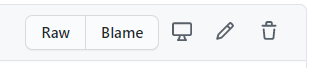

虽然 Python 提供了一个处理 HTTP 查询的库（'urllib'），但人们通常更喜欢使用第三方 'requests'，因为用法要简单得多。

In [2]:
import requests

url = "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv"
response = requests.get(url)
response.raise_for_status()
response

# NBVAL_CHECK_OUTPUT

<Response [200]>

当您使用 'requests.get（...）' 会获得一个 'Response' 对象。这不是您要下载的文件，而是一个包装 HTTP 查询和服务器给您的 _response_ 的对象。在我们检查内容之前，我们总是调用 '.raise_for_status（）'，如果服务器告诉我们请求无法完成，它将引发异常。服务器是怎么做到的呢？带有[HTTP 状态代码](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)的 3 位数字。有几种，但最常见的是：
* 200：一切都好！
* 404：找不到文件。
* 500：服务器错误。

如果你的响应没有获得 200 代码，'.raise_for_status（）' 将会抱怨。因此，最好在 _every_ 查询之后调用它！

请看这个错误 URL 的例子，它包含一个错误：那里没有 **TXT** 文件，只有一个 **CSV**。

In [3]:
# NBVAL_RAISES_EXCEPTION
bad_url = "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.txt"
bad_response = requests.get(bad_url)
bad_response.raise_for_status()
bad_response

HTTPError: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.txt

好，现在让我们来看看 CSV 文件的内容吧！根据您要查找的内容，您将需要以下属性之一：

* 'response.content'：服务器返回的 _bytes_。
* 'response.text'：文件的内容，如果可能，以字符串形式显示。
* 'response.json（）'：如果服务器返回 JSON 数据（稍后会详细介绍），此方法将解析它并返回相应的字典。

您应该使用哪一个？如果要在 Notebook 输出中显示一些 _text_，请选择 '.text'。所有涉及二进制文件（图像、档案、PDF 等）或下载到磁盘的内容都应该使用 '.content'。

由于这是一个 CSV 文件，我们知道这是一个纯文本文件，因此我们可以对它使用通常的 Python 方法！让我们打印前 10 行：

In [4]:
print(*response.text.splitlines()[:10], sep="\n")

xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein kinase 4,Atypical,ABC1,ABC1-A,Q96D53
Trb1,Trb1,TRIB1,Tribbles homolog 1,CAMK,Trbl,,Q96RU8
BRSK2,BRSK2,BRSK2,Serine/threonine-protein kinase BRSK2,CAMK,CAMKL,BRSK,Q8IWQ3
Wnk2,Wnk2,WNK2,Serine/threonine-protein kinase WNK2,Other,WNK,,Q9Y3S1
AKT1,AKT1,AKT1,RAC-alpha serine/threonine-protein kinase,AGC,Akt,,P31749


当然，您可以使用通常的 Python 构造将其保存到磁盘。由于我们正在 _downloading_，因此建议使用原始字节内容，而不是文本版本！这意味着你应该使用 'response.content' 并以字节模式（'wb' 中的 'b'）打开你的文件：

In [5]:
with open(TMPDATA / "kinhub.csv", "wb") as f:
    f.write(response.content)

再次打开它以检查我们编写了一些内容。

In [6]:
# We need the encoding="utf-8-sig" to ensure correct encoding
# under all platforms
with open(TMPDATA / "kinhub.csv", encoding="utf-8-sig") as f:
    # Zip will stop iterating with the shortest iterator
    # passing `range(5)` allow us to just get five lines ;)
    for _, line in zip(range(5), f):
        print(line.rstrip())

# NBVAL_CHECK_OUTPUT

xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705


 **提示**：如果您只想下载一个 CSV 文件以使用 Pandas 打开它，那么只需将原始 URL 传递给“pandas.read_csv”。它将为您下载文件！

In [7]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv"
)
df.head()
# NBVAL_CHECK_OUTPUT

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912
2,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
3,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
4,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53


关于文件下载的一点说明。上述方法将整个文件下载到内存中，这对于非常大的文件来说可能是一个问题。如果您打算下载一个非常大的文件，您可以使用 [streaming requests](https://requests.readthedocs.io/en/master/user/advanced/#streaming-requests) 和 [raw responses](https://docs.python-requests.org/en/v1.1.0/user/quickstart/?highlight=raw%20response#raw-response-content)直接将其推送到磁盘。例如，让我们假设这个 [1MB 视频](https://archive.org/download/SlowMotionFlame/slomoflame_512kb.mp4)_非常大，无法放入memory_：

In [8]:
import shutil
from IPython.display import Video

response = requests.get(
    "https://archive.org/download/SlowMotionFlame/slomoflame_512kb.mp4", stream=True
)
response.raise_for_status()

with open(TMPDATA / "video.mp4", "wb") as tmp:
    for chunk in response.iter_content(chunk_size=8192):
        tmp.write(chunk)

    # Let's play the movie in Jupyter!
    # Paths passed to widgets need to be relative to notebook or they will 404 :)
    display(Video(Path(tmp.name).relative_to(HERE)))

### 访问动态生成的内容

到目前为止，我们已经能够检索远程服务器上存在的 _files_。为此，我们使用了 'requests.get' 和指向该文件的 URL。

好吧，事实证明，相同的技术将适用于更多类型的内容！服务器如何处理 URL 不是我们关心的！服务器是只需要在磁盘上给你一个文件，还是查询一个数据库，并将不同的部分组装成返回的内容，这根本不重要。

正如您现在将看到的那样，仅这个概念就非常强大。请记住： **我们只需要确保我们请求的 URL 正确！

现在让我们做一些有趣的事情吧！SARS-CoV-2 中的刺突蛋白是最近最流行的蛋白质之一，我们可以使用“请求”从 [UniProt]（https://www.uniprot.org/） 获取一些信息吗？它的 UniProt ID 是 'P0DTC2'。[先用浏览器检查]（https://www.uniprot.org/uniprot/P0DTC2），您应该会看到如下内容：

![UniProt entry for SARS-CoV-2](images/uniprot-sars-cov-2.jpg)
UniProt 提供的其中一项功能是所列蛋白质的氨基酸序列。向下滚动，直到看到这部分：

![Sequence for SARS-CoV-2](images/uniprot-sars-cov-2-sequence.jpg)

你认为我们可以使用 Python _only_ 获得序列吗？我看看！

要查询蛋白质，您只需将其 UniProt ID 添加到 URL 中。

In [9]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2")
r.raise_for_status()
print(r.text[:5000])

<!doctype html><html lang="en"><head><meta charset="utf-8"/><title>UniProt</title><meta name="viewport" content="width=device-width,initial-scale=1"/><meta name="theme-color" content="#00639a"/><link rel="apple-touch-icon" sizes="180x180" href="/apple-touch-icon.png"/><link rel="shortcut icon" type="image/png" sizes="144x144" href="/mstile-144x144.png"/><link rel="icon" type="image/png" sizes="32x32" href="/favicon-32x32.png"/><link rel="icon" type="image/png" sizes="16x16" href="/favicon-16x16.png"/><link rel="manifest" href="/manifest.json"/><link rel="preconnect" href="https://fonts.gstatic.com/"/><link rel="preconnect" href="https://rest.uniprot.org/"/><link rel="preload" as="style" href="https://fonts.googleapis.com/css?family=Lato:400,700|Source+Sans+Pro:600,700&display=swap"/><script async src="https://www.googletagmanager.com/gtag/js?id=G-V6TXEC4BDF"></script><script>window.dataLayer = window.dataLayer || [];
      function gtag() {
        dataLayer.push(arguments);
      }
  

Wow, what is all that noise? You are seeing the HTML content of the webpage! That's the markup language web developers use to write webpages.

There are libraries to process HTML and extract the actual content (like `BeautifulSoup`; more below), but we will not need it here yet. Fortunately, UniProt provides alternative representations of the data.

![UniProt formats](images/uniprot-sars-cov-2-formats.jpg)

Some formats are more convenient for programmatic use. If you click on `Text` you will see something different in your browser: just plain text! Also, notice how the URL is now different.

* HTML representation (default): https://www.uniprot.org/uniprot/P0DTC2
* Text representation: https://www.uniprot.org/uniprot/P0DTC2.txt

Just adding the `.txt` extension was enough to change the style. This is a nice feature UniProt provides. It mimics a file system, but it's actually changing the representation of the returned content. Elegant! And more important, easier to use programmatically! Check it:

In [10]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2.txt")
r.raise_for_status()
print(r.text[:1000])

ID   SPIKE_SARS2             Reviewed;        1273 AA.
AC   P0DTC2;
DT   22-APR-2020, integrated into UniProtKB/Swiss-Prot.
DT   22-APR-2020, sequence version 1.
DT   03-MAY-2023, entry version 16.
DE   RecName: Full=Spike glycoprotein {ECO:0000255|HAMAP-Rule:MF_04099};
DE            Short=S glycoprotein {ECO:0000255|HAMAP-Rule:MF_04099};
DE   AltName: Full=E2 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   AltName: Full=Peplomer protein {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S1 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S2 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S2' {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Flags: Precursor;
GN   Name=S {ECO:0000255|HAMAP-Rule:MF_04099}; ORFNames=2;
OS   Severe acute respiratory syndrome coronavirus 2 (2019-nCoV) (SARS-CoV-2).
OC   Viruses; Riboviria; Orthornavirae; Pisuviricota; Pisoniviricetes;
OC   Nidovirales; Cornidovirineae;

This is _exactly_ what we see on our browser! Plain text is nice for these things. However, the sequence is all the way at the end of the file. To retrieve it, you need to get creative and analyze those little tags each line has. See how it begins with `SQ` and finishes with `//`:

```
SQ   SEQUENCE   1273 AA;  141178 MW;  B17BE6D9F1C4EA34 CRC64;
     MFVFLVLLPL VSSQCVNLTT RTQLPPAYTN SFTRGVYYPD KVFRSSVLHS TQDLFLPFFS
     NVTWFHAIHV SGTNGTKRFD NPVLPFNDGV YFASTEKSNI IRGWIFGTTL DSKTQSLLIV
     NNATNVVIKV CEFQFCNDPF LGVYYHKNNK SWMESEFRVY SSANNCTFEY VSQPFLMDLE
     GKQGNFKNLR EFVFKNIDGY FKIYSKHTPI NLVRDLPQGF SALEPLVDLP IGINITRFQT
     LLALHRSYLT PGDSSSGWTA GAAAYYVGYL QPRTFLLKYN ENGTITDAVD CALDPLSETK
     CTLKSFTVEK GIYQTSNFRV QPTESIVRFP NITNLCPFGE VFNATRFASV YAWNRKRISN
     CVADYSVLYN SASFSTFKCY GVSPTKLNDL CFTNVYADSF VIRGDEVRQI APGQTGKIAD
     YNYKLPDDFT GCVIAWNSNN LDSKVGGNYN YLYRLFRKSN LKPFERDIST EIYQAGSTPC
     NGVEGFNCYF PLQSYGFQPT NGVGYQPYRV VVLSFELLHA PATVCGPKKS TNLVKNKCVN
     FNFNGLTGTG VLTESNKKFL PFQQFGRDIA DTTDAVRDPQ TLEILDITPC SFGGVSVITP
     GTNTSNQVAV LYQDVNCTEV PVAIHADQLT PTWRVYSTGS NVFQTRAGCL IGAEHVNNSY
     ECDIPIGAGI CASYQTQTNS PRRARSVASQ SIIAYTMSLG AENSVAYSNN SIAIPTNFTI
     SVTTEILPVS MTKTSVDCTM YICGDSTECS NLLLQYGSFC TQLNRALTGI AVEQDKNTQE
     VFAQVKQIYK TPPIKDFGGF NFSQILPDPS KPSKRSFIED LLFNKVTLAD AGFIKQYGDC
     LGDIAARDLI CAQKFNGLTV LPPLLTDEMI AQYTSALLAG TITSGWTFGA GAALQIPFAM
     QMAYRFNGIG VTQNVLYENQ KLIANQFNSA IGKIQDSLSS TASALGKLQD VVNQNAQALN
     TLVKQLSSNF GAISSVLNDI LSRLDKVEAE VQIDRLITGR LQSLQTYVTQ QLIRAAEIRA
     SANLAATKMS ECVLGQSKRV DFCGKGYHLM SFPQSAPHGV VFLHVTYVPA QEKNFTTAPA
     ICHDGKAHFP REGVFVSNGT HWFVTQRNFY EPQIITTDNT FVSGNCDVVI GIVNNTVYDP
     LQPELDSFKE ELDKYFKNHT SPDVDLGDIS GINASVVNIQ KEIDRLNEVA KNLNESLIDL
     QELGKYEQYI KWPWYIWLGF IAGLIAIVMV TIMLCCMTSC CSCLKGCCSC GSCCKFDEDD
     SEPVLKGVKL HYT
//
```

Hence, you could do something like this:

In [11]:
sequence_block = False
lines = []
for line in r.text.splitlines():
    if line.startswith("SQ"):
        sequence_block = True
    elif line.startswith("//"):
        sequence_block = False

    if sequence_block:
        line = line.strip()  # delete spaces and newlines at the beginning and end of the line
        line = line.replace(" ", "")  # delete spaces in the middle of the line
        lines.append(line)
sequence = "".join(lines[1:])  # the first line is the metadata header
print(f"This is your sequence: {sequence}")

# NBVAL_CHECK_OUTPUT

This is your sequence: MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVL

Ta-da! We got it! It required some processing, but it works... However, you should always wonder if there's an easier way. Given that UniProt had a nice way of providing the text representation, how come they don't offer a URL that _only_ returns the sequence for a given UniProt ID? Well, they do! Just change `.txt` for `.fasta`: https://www.uniprot.org/uniprot/P0DTC2.fasta

In [12]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2.fasta")
r.raise_for_status()
print(r.text)

# NBVAL_CHECK_OUTPUT

>sp|P0DTC2|SPIKE_SARS2 Spike glycoprotein OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049 GN=S PE=1 SV=1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT
LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK
CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN
CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD
YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC
NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN
FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP
GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY
ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI
SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE
VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC
LGDIAARDLICAQKFNGLTVLPPLLTD

This is returned in FASTA, a common syntax in bioinformatics. You could use established libraries like [BioPython](https://biopython.org/) to parse it too!

In [13]:
from Bio import SeqIO
from tempfile import NamedTemporaryFile
import os

# Write response into a temporary text file
with NamedTemporaryFile(suffix=".fasta", mode="w", delete=False) as tmp:
    tmp.write(r.text)

# Create the BioPython object for sequence data:
sequence = SeqIO.read(tmp.name, format="fasta")

# Delete temporary file now that we have read it
os.remove(tmp.name)

print(sequence.description)
print(sequence.seq)

# NBVAL_CHECK_OUTPUT

sp|P0DTC2|SPIKE_SARS2 Spike glycoprotein OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049 GN=S PE=1 SV=1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTI

All these ways to access different representations or sections of the data contained in UniProt constitutes a URL-based API (Application Programmatic Interface). The foundational principle is that the URL contains all the **parameters** needed to ask the server for a specific type of content. Yes, you read that correctly: **parameters**. If you think about it, a URL specifies two parts: the machine you are connecting to and the page in that machine you want to access. When the page part is missing, the server assumes you are asking for `index.html` or equivalent.

Let's compare it to a command-line interface:

```
@ # this is your browser
@ uniprot.org/uniprot/P0DTC2.fasta
```

```bash
$ # this is your terminal
$ uniprot --id=P0DTC2 --format=FASTA
```

Each part of the URL can be considered a positional argument! So, if you want the sequence of a different protein, just input its UniProt ID in the URL, done! For example, `P00519` is the ID for the ABL1 kinase.

In [14]:
r = requests.get("https://www.uniprot.org/uniprot/P00519.fasta")
r.raise_for_status()
print(r.text)

# NBVAL_CHECK_OUTPUT

>sp|P00519|ABL1_HUMAN Tyrosine-protein kinase ABL1 OS=Homo sapiens OX=9606 GN=ABL1 PE=1 SV=4
MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSE
NDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN
SLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTAS
DGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERT
DITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQ
LLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFI
HRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKS
DVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNP
SDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAE
HRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLF
SALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSP
KPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSAS
CVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTV
TPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGS
ALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLS

What if we parameterize the URL with an f-string and provide a function to make it super Pythonic? Even better, what if we provide the `Bio.SeqIO` parsing functionality too?

In [15]:
def sequence_for_uniprot_id(uniprot_id):
    """
    Returns the FASTA sequence of a given Uniprot ID using
    the UniProt URL-based API

    Parameters
    ----------
    uniprot_id : str

    Returns
    -------
    Bio.SeqIO.SeqRecord
    """
    #                                                  ⬇ this is key part!
    r = requests.get(f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta")
    r.raise_for_status()

    with NamedTemporaryFile(suffix=".fasta", mode="w", delete=False) as tmp:
        tmp.write(r.text)

    sequence = SeqIO.read(tmp.name, format="fasta")
    os.remove(tmp.name)

    return sequence

Now you can use it for any UniProt ID. This is for the [Src kinase](https://www.uniprot.org/uniprot/P12931):

In [16]:
sequence = sequence_for_uniprot_id("P12931")
print(sequence)

# NBVAL_CHECK_OUTPUT

ID: sp|P12931|SRC_HUMAN
Name: sp|P12931|SRC_HUMAN
Description: sp|P12931|SRC_HUMAN Proto-oncogene tyrosine-protein kinase Src OS=Homo sapiens OX=9606 GN=SRC PE=1 SV=3
Number of features: 0
Seq('MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAF...ENL', SingleLetterAlphabet())


Congratulations! You have used your first online API in Python and adapted it to a workflow!

### Programmatic interfaces

What UniProt does with their URLs is _one way_ of providing access to their database, i.e., through specific URL schemes. However, if each web service would have to come up with their own scheme, developers would need to figure out which scheme the website is using, and then implement, adapt or customize their scripts on a case-by-case basis. Fortunately, there are some standardized ways of providing programmatic access to online resources. Some of them include:

- HTTP-based RESTful APIs ([wiki](https://en.wikipedia.org/wiki/Representational_state_transfer#Applied_to_Web_services))
- GraphQL
- SOAP
- gRPC

In this talktorial, we will focus on the first one, [REST](https://en.wikipedia.org/wiki/Representational_state_transfer).

#### HTTP-based RESTful APIs

This type of programmatic access defines a specific entry point for clients (scripts, libraries, programs) that require programmatic access, something like `api.webservice.com`. This is usually different from the website itself (`webservice.com`). They can be versioned, so the provider can update the scheme without disrupting existing implementations (`api.webservice.com/v1` will still work even when `api.webservice.com/v2` has been deployed).

This kind of API is usually accompanied by well-written documentation explaining all the available actions in the platform. For example, look at the [KLIFS API documentation](https://klifs.net/swagger). KLIFS is a database of kinase targets and small compound inhibitors. You can see how every argument and option is documented, along with usage examples. 

If you wanted to list all the kinase families available in KLIFS, you need to access this URL:

```
https://klifs.net/api/kinase_groups
```

<details>
    <summary>
        Result (click here!)
    </summary>

```
[
  "AGC",
  "CAMK",
  "CK1",
  "CMGC",
  "Other",
  "STE",
  "TK",
  "TKL"
]
```
    

</details>


This response happens to be [JSON](https://en.wikipedia.org/wiki/JSON)-formatted! This is easily parsed into a Python object using the `json` library. The best news is that you don't even need that. Using `requests`, the following operation can be done in three lines thanks to the `.json()` method:

In [17]:
import requests

response = requests.get("https://klifs.net/api/kinase_groups")
response.raise_for_status()
result = response.json()
result

# NBVAL_CHECK_OUTPUT

['AGC', 'CAMK', 'CK1', 'CMGC', 'Other', 'STE', 'TK', 'TKL']

That's a Python `list`!

In [18]:
result[0]

'AGC'

Let's see if we can get all the kinase _families_ contained in a specific group. Reading the documentation, looks like we need this kind of URL:

```
https://klifs.net/api/kinase_families?kinase_group={{ NAME }}
```

> What follows after the `?` symbol is the _query_. It's formatted with a key-value syntax like this: `key=value`. Multiple parameters can be expressed with `&`:
> 
> ```
> https://api.webservice.com/some/endpoint?parameter1=value1&parameter2=value2
> ```

Let's see the returned object for the tyrosine kinase (TK) group: `family=TK`

In [19]:
response = requests.get("https://klifs.net/api/kinase_families?kinase_group=TK")
response.raise_for_status()
result = response.json()
result

['ALK',
 'Abl',
 'Ack',
 'Alk',
 'Axl',
 'CCK4',
 'Csk',
 'DDR',
 'EGFR',
 'Eph',
 'FAK',
 'FGFR',
 'Fer',
 'InsR',
 'JakA',
 'JakB',
 'Lmr',
 'Met',
 'Musk',
 'PDGFR',
 'Ret',
 'Ror',
 'Ryk',
 'Sev',
 'Src',
 'Syk',
 'TK-Unique',
 'Tec',
 'Tie',
 'Trk',
 'VEGFR']

Since passing parameters to the URL is a very common task, `requests` provides a more convenient way. This will save you from building the URLs manually or HTML escaping the values. The key idea is to pass the key-value pairs as a dictionary. The previous query can be (and should be, if you ask us) done like this:

In [20]:
response = requests.get("https://klifs.net/api/kinase_families", params={"kinase_group": "TK"})
# You can see how requests formatted the URL for you
print("Queried", response.url)
response.raise_for_status()
result = response.json()
result

Queried https://klifs.net/api/kinase_families?kinase_group=TK


['ALK',
 'Abl',
 'Ack',
 'Alk',
 'Axl',
 'CCK4',
 'Csk',
 'DDR',
 'EGFR',
 'Eph',
 'FAK',
 'FGFR',
 'Fer',
 'InsR',
 'JakA',
 'JakB',
 'Lmr',
 'Met',
 'Musk',
 'PDGFR',
 'Ret',
 'Ror',
 'Ryk',
 'Sev',
 'Src',
 'Syk',
 'TK-Unique',
 'Tec',
 'Tie',
 'Trk',
 'VEGFR']

Sometimes the returned JSON object is not a list, but a dict. Or a combination of dictionaries and lists. Maybe even nested! You can still access them using the Python tools you already know.

For example, the `kinase_information` endpoint _requires_ a numeric ID, and will return a lot of information on a single kinase:

In [21]:
response = requests.get("https://klifs.net/api/kinase_information", params={"kinase_ID": 22})
response.raise_for_status()
result = response.json()
result

# NBVAL_CHECK_OUTPUT

[{'kinase_ID': 22,
  'name': 'MASTL',
  'HGNC': 'MASTL',
  'family': 'MAST',
  'group': 'AGC',
  'kinase_class': 'MASTL',
  'species': 'Human',
  'full_name': 'microtubule associated serine/threonine kinase like',
  'uniprot': 'Q96GX5',
  'iuphar': 0,
  'pocket': 'KPISRGAFGKVYLYAVKVVQVQAERDALALSKPFIVHLYYSYLVMEYLIGGDVKSLLHIYLHRHGIIHRDLKPDNMLILTDFGLS'}]

If you want to know the UniProt ID for this kinase, you will need to access the first (and only) element in the returned list, and ask for the value of the `uniprot` key:

In [22]:
result[0]["uniprot"]

'Q96GX5'

Turns out we can use this to get the full sequence of the protein (and not just the pocket sequence) using our UniProt function from before!

In [23]:
mastl = sequence_for_uniprot_id(result[0]["uniprot"])
print(mastl.seq)

# NBVAL_CHECK_OUTPUT

MDPTAGSKKEPGGGAATEEGVNRIAVPKPPSIEEFSIVKPISRGAFGKVYLGQKGGKLYAVKVVKKADMINKNMTHQVQAERDALALSKSPFIVHLYYSLQSANNVYLVMEYLIGGDVKSLLHIYGYFDEEMAVKYISEVALALDYLHRHGIIHRDLKPDNMLISNEGHIKLTDFGLSKVTLNRDINMMDILTTPSMAKPRQDYSRTPGQVLSLISSLGFNTPIAEKNQDPANILSACLSETSQLSQGLVCPMSVDQKDTTPYSSKLLKSCLETVASNPGMPVKCLTSNLLQSRKRLATSSASSQSHTFISSVESECHSSPKWEKDCQESDEALGPTMMSWNAVEKLCAKSANAIETKGFNKKDLELALSPIHNSSALPTTGRSCVNLAKKCFSGEVSWEAVELDVNNINMDTDTSQLGFHQSNQWAVDSGGISEEHLGKRSLKRNFELVDSSPCKKIIQNKKTCVEYKHNEMTNCYTNQNTGLTVEVQDLKLSVHKSQQNDCANKENIVNSFTDKQQTPEKLPIPMIAKNLMCELDEDCEKNSKRDYLSSSFLCSDDDRASKNISMNSDSSFPGISIMESPLESQPLDSDRSIKESSFEESNIEDPLIVTPDCQEKTSPKGVENPAVQESNQKMLGPPLEVLKTLASKRNAVAFRSFNSHINASNNSEPSRMNMTSLDAMDISCAYSGSYPMAITPTQKRRSCMPHQQTPNQIKSGTPYRTPKSVRRGVAPVDDGRILGTPDYLAPELLLGRAHGPAVDWWALGVCLFEFLTGIPPFNDETPQQVFQNILKRDIPWPEGEEKLSDNAQSAVEILLTIDDTKRAGMKELKRHPLFSDVDWENLQHQTMPFIPQPDDETDTSYFEARNTAQHLTVSGFSL


We are using two webservices together, awesome!

#### Generating a client for any API

Did you find that convenient? Well, we are not done yet! You might have noticed that all the endpoints in the KLIFS API have a similar pattern. You specify the name of the endpoint (`kinase_groups`, `kinase_families`, `kinase_information`, ...), pass some (optional) parameters if needed, and then get a JSON-formatted response. Is there a way you can avoid having to format the URLs yourself? The answer is... yes!

The REST API scheme can be expressed programmatically in a document called [Swagger/OpenAPI definitions](https://swagger.io/docs/specification/about/), which allows to dynamically generate a Python client for any REST API that implements the Swagger/OpenAPI schema. [This is the one for KLIFS](https://klifs.net/swagger/swagger.json).

Of course, there are libraries for doing that in Python, like `bravado`.

In [24]:
from bravado.client import SwaggerClient

KLIFS_SWAGGER = "https://klifs.net/swagger/swagger.json"
client = SwaggerClient.from_url(KLIFS_SWAGGER, config={"validate_responses": False})
client

SwaggerClient(https://klifs.net/api)

Then, you can have fun inspecting the `client` object for all the API actions as methods.

ℹ __Tip__: Type `client.` and press <kbd>Tab</kbd> to inspect the client in this notebook.

In [25]:
?client.Information.get_kinase_names

`bravado` is auto-generating classes and functions that mirror the API we were using before! How cool is that? The same query can now be done without requests.

In [26]:
client.Information.get_kinase_information(kinase_ID=[22])

Note that `bravado` does _not_ return the response right away. It creates a _promise_ that it will do so when you ask for it. This allows it to be usable in asynchronous programming, but for our purposes, it means that you need to call it with `.result()`.

In [27]:
results = client.Information.get_kinase_information(kinase_ID=[22]).result()
result = results[0]
result

KinaseInformation(HGNC='MASTL', family='MAST', full_name='microtubule associated serine/threonine kinase like', group='AGC', iuphar=0, kinase_ID=22, kinase_class='MASTL', name='MASTL', pocket='KPISRGAFGKVYLYAVKVVQVQAERDALALSKPFIVHLYYSYLVMEYLIGGDVKSLLHIYLHRHGIIHRDLKPDNMLILTDFGLS', species='Human', uniprot='Q96GX5')

In [28]:
result.uniprot

# NBVAL_CHECK_OUTPUT

'Q96GX5'

`bravado` also builds result _objects_ for you, so you don't have to use the `result["property"]` syntax, but the `result.property` one. Some more convenience for the end user ;)

### Document parsing

Sometimes the web service will not provide a standardized API that produces machine-readable documents. Instead, you will have to use the regular webpage and parse through the HTML code to obtain the information you need. This is called (web) __scraping__, which usually involves finding the right HTML tags and IDs that contain the valuable data (ignoring things such as the sidebars, top menus, footers, ads, etc).

In scraping, you basically do two things:

1. Access the webpage with `requests` and obtain the HTML contents.
2. Parse the HTML string with `BeautifulSoup` or `requests-html`.


Let's parse the proteinogenic amino acids table in this [Wikipedia article](https://en.wikipedia.org/wiki/Proteinogenic_amino_acid):

In [29]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

r = requests.get("https://en.wikipedia.org/wiki/Proteinogenic_amino_acid")
r.raise_for_status()

# To guess the correct steps here, you will have to inspect the HTML code by hand
# Tip: use right-click + inspect content in any webpage to land in the HTML definition ;)
html = BeautifulSoup(r.text)
header = html.find("span", id="General_chemical_properties")
table = header.find_all_next()[4]
table_body = table.find("tbody")

data = []
for row in table_body.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        data.append([])
    for cell in cells:
        cell_content = cell.text.strip()
        try:  # convert to float if possible
            cell_content = float(cell_content)
        except ValueError:
            pass
        data[-1].append(cell_content)

# Empty fields are denoted with "?" which casts respective columns to object types
# (here mix of strings and floats) but we want float64, therefore replace "?" with NaN values
pd.DataFrame.from_records(data).replace("?", np.nan)

# NBVAL_CHECK_OUTPUT

,0,1,2,3,4,5
0,A,Ala,89.09404,6.01,2.35,9.87
1,C,Cys,121.15404,5.05,1.92,10.70
2,D,Asp,133.10384,2.85,1.99,9.90
3,E,Glu,147.13074,3.15,2.10,9.47
4,F,Phe,165.19184,5.49,2.20,9.31
5,G,Gly,75.06714,6.06,2.35,9.78
6,H,His,155.15634,7.60,1.80,9.33
7,I,Ile,131.17464,6.05,2.32,9.76
8,K,Lys,146.18934,9.60,2.16,9.06
9,L,Leu,131.17464,6.01,2.33,9.74


### Browser remote control

The trend some years ago was to build servers that dynamically generate HTML documents with some JavaScript here and there (such as Wikipedia). In other words, the HTML is built in the server and sent to the client (your browser).

However, latest trends are pointing towards full applications built entirely with JavaScript frameworks. This means that the HTML content is dynamically generated in the client. Traditional parsing will not work and you will only download the placeholder HTML code that hosts the JavaScript framework. To work around this, the HTML must be rendered with a client-side JavaScript engine.

We won't cover this in the current notebook, but you can check the following projects if you are interested:

- [puppeteer](https://github.com/GoogleChrome/puppeteer)
- [selenium](https://www.seleniumhq.org/)

***

## Discussion

In this theoretical introduction you have seen how different methods to programmatically access online web services can be used from a Python interpreter. Leveraging these techniques you will be able to build automated pipelines inside Jupyter Notebooks. In the end, querying a database or downloading a file involves the same kind of tooling.

Unfortunately, there is too much material to cover about web APIs in a single lesson. For example, how do you _send_ or _upload_ contents from Python? Can you submit forms? If you are interested in knowing more, the `requests` [documentation](https://requests.readthedocs.io/) should be your go-to resource. Some interesting parts include:

* [Submitting forms with POST requests](https://docs.python-requests.org/en/v1.1.0/user/quickstart/#more-complicated-post-requests)
* [User authentication](https://docs.python-requests.org/en/v1.1.0/user/authentication/#basic-authentication)

## Quiz

* Use the KLIFS API (with or without `bravado`, up to you) to find all kinases that can bind staurosporine (ligand code `STU`).
* How can you find the correct HTML tags and identifiers to scrape a specific part of a website? Can it be automated?
* Would you rather use programmatic APIs or manually crafted scrapers?